In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from sklearn.cluster import SpectralClustering
from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding
from sklearn import preprocessing
from itertools import cycle, islice
import collections
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import imageio.v2 as imageio

# Fonctions

In [3]:
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [4]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors


In [5]:
def affiche(X, dim, nb_cluster, gamma = 20, g = 50, affinity = 'rbf', neighbors = 7, n_neighbors = 7, label = 'discretize'):
    plt.figure(figsize = (24,(int(dim*(dim - 1) / 12) + 1)*3))
    plt.suptitle(f'Graphiques des différentes dimensions pour {nb_cluster} cluster et avec la méthode {affinity}')
    plt.subplots_adjust(hspace=0.3)
    emb = SpectralEmbedding(n_components=dim, gamma = g, affinity= affinity, n_neighbors = neighbors)
    X_transformed = emb.fit_transform(X)
    num_plot = 1
    for i in range(dim):
        for j in range(i+1, dim):
            clustering = SpectralClustering(n_clusters=nb_cluster, assign_labels=label, random_state=0, affinity=affinity, gamma = gamma, n_neighbors = n_neighbors).fit(X)
            y_pred = clustering.labels_
            plt.subplot(int(dim*(dim - 1) / 12) + 1,6,num_plot)
            plt.title(f"Dimension {i+1} et {j+1}")
            scatter = plt.scatter(X_transformed[:,i], X_transformed[:,j], c = y_pred)
            num_plot += 1
    plt.tight_layout(rect = [0, 0, 1, 0.975])
    plt.show()

In [6]:
def affiche_vect_1D_V3(dim, t, G):
    x = np.linspace(1,len(t[0][0]),len(t[0][0]))
    zero = np.zeros(len(t[0]))
    for i in range(dim):
        for k in range(len(G)):
            plt.figure(figsize = (8,6))
            plt.title(f'Graphiques pour les vecteurs propres, Dimension {i+1}')
            plt.plot(x, t[k][:,i], label = G[k])
            plt.legend(title="Gamma")
            plt.savefig(f'{i}_{k}.png')
            plt.show()

In [7]:
def gif_V1(dim, G):
    liste = []
    for k in range(len(G)):
        for i in range(3):
            liste.append(f'{dim}_{k}.png')
    with imageio.get_writer(f'Gif_V2_{dim}.gif', mode='I') as writer:
        for filename in liste:
            image = imageio.imread(filename)
            writer.append_data(image)

In [8]:
def remove_im(dim,G):
    for i in range(dim):
        for j in range(len(G)):
            os.remove(f'{i}_{j}.png')

In [9]:
df = pd.read_excel('Proportion.xlsx')

X = df[df.columns[1:-1]]
Y = df[df.columns[-1]]

X1 = X.T

### Choix des paramètres

On va maintenant tenter de modifier les paramètres et voir leur impact, puis nous chercherons quels sont les paramètres optimaux.

Essayons de regarder si en changeant gamma nos vecteur propres restent sensiblement les mêmes où s'il y a une grosse modification.

Nous essayeront ensuite d'afficher tous les vecteurs propres pour voir comment ils évoluent suivant gamma et si on peut observer quelque chose d'intéressant.

In [9]:
G = np.linspace(1,100,100)
t = []

for i in G:
    embedding = SpectralEmbedding(n_components = 48, affinity='rbf', gamma = i)
    X_transformed = embedding.fit_transform(X)
    _, e,  k = eigenDecomposition(embedding.affinity_matrix_, plot = False)
    t.append(k)

In [10]:
t[0].shape

(50, 50)

In [11]:
t[0].shape

(50, 50)

In [12]:
#affiche_vect(len(t), t)
#affiche_vect_1D_V1(8, t, G)
#affiche_vect_1D_V2(len(t), t, G)
#affiche_vect_1D_V3(len(t), t, G)

#affiche_vect_1D_V4(50, t, G, 10)

#for i in range(50):
#    gif(i, G, 10)

#remove_im(50,G,10)

In [13]:
#affiche_vect_1D_V3(50, t, G)

#for i in range(50):
    #gif_V1(i, G)

#remove_im(50,G)

### Choix des paramètres optimaux

On va chercher à modifier tous les paramètres afin de trouver la combinaison la plus optimale. On modifiera : 'Assign_label', 'nb_cluster', 'affinity', 'gamma', 'n_neighbors'

In [9]:
nb_cluster = 6

clustering = SpectralClustering(n_clusters=nb_cluster, assign_labels='discretize', random_state=0, affinity= 'rbf').fit(X)
y_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=nb_cluster, assign_labels='discretize', random_state=0, affinity= 'nearest_neighbors').fit(X)
y_pred1 = clustering.labels_

clustering = SpectralClustering(n_clusters=nb_cluster, assign_labels='kmeans', random_state=0, affinity= 'rbf').fit(X)
y_pred2 = clustering.labels_

clustering = SpectralClustering(n_clusters=nb_cluster, assign_labels='kmeans', random_state=0, affinity= 'nearest_neighbors').fit(X)
y_pred3 = clustering.labels_

#clustering = SpectralClustering(n_clusters=6, assign_labels='cluster_qr', random_state=0, affinity= 'rbf').fit(X)
#y_pred4 = clustering.labels_

#clustering = SpectralClustering(n_clusters=6, assign_labels='cluster_qr', random_state=0, affinity= 'nearest_neighbors').fit(X)
#y_pred5 = clustering.labels_

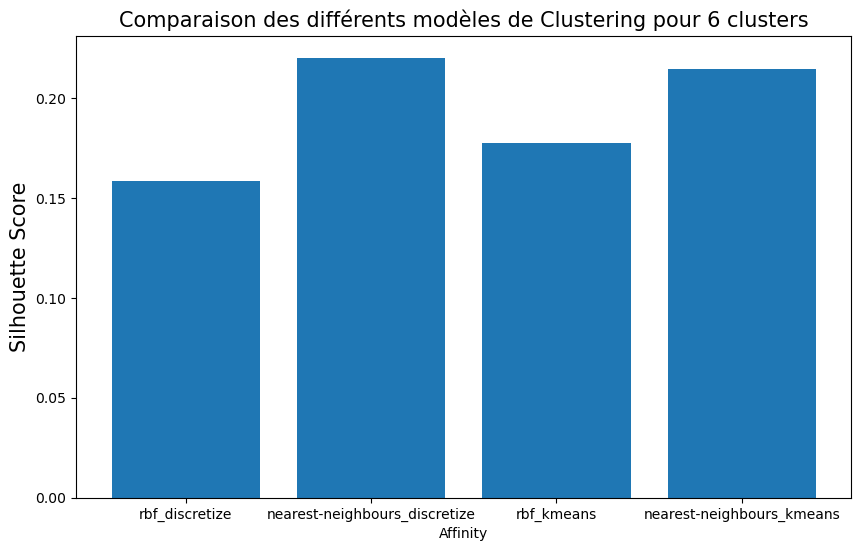

[0.15859631763619372, 0.2201859677314956, 0.177539199676667, 0.21471617292780354]


In [10]:
from sklearn.metrics import silhouette_score 

# List of different values of affinity 
affinity = ['rbf_discretize', 'nearest-neighbours_discretize', 'rbf_kmeans', 'nearest-neighbours_kmeans']#, 'rbf_clusterqr', 'nearest-neighbours_clusterqr'] 
  
# List of Silhouette Scores 
s_scores = [] 
  
# Evaluating the performance 
s_scores.append(silhouette_score(X, y_pred)) 
s_scores.append(silhouette_score(X, y_pred1)) 
s_scores.append(silhouette_score(X, y_pred2)) 
s_scores.append(silhouette_score(X, y_pred3)) 
#s_scores.append(silhouette_score(X, y_pred4)) 
#s_scores.append(silhouette_score(X, y_pred5)) 
  
# Plotting a Bar Graph to compare the models 
plt.figure(figsize=(10,6))
plt.bar(affinity, s_scores) 
plt.xlabel('Affinity') 
plt.ylabel('Silhouette Score', fontsize=15) 
plt.title(f'Comparaison des différents modèles de Clustering pour {nb_cluster} clusters', fontsize=15) 
plt.show() 

print(s_scores)

Sans avoir modifié gamma et le nombre de voisin, on obtiens les scores ci-dessus. On va  maintenant chercher les combinaisons (gamma, nombre de cluster) puis (nombre de voisin, nombre de cluster) optimal :

In [17]:
G = np.linspace(5,100,39)
nb_cluster = [4,5,6,7,8,9,10,11,12,14,16,20]
Score = []
for i in range(len(G)):
    for j in range(len(nb_cluster)):
        clustering = SpectralClustering(n_clusters=nb_cluster[j], assign_labels='discretize', random_state=0, affinity= 'rbf', gamma = G[i]).fit(X)
        Pred = clustering.labels_
        Score.append(silhouette_score(X, Pred))

temp = []
index = []
taille = 10

for i in range(taille):
    index.append(Score.index(max(Score)))
    temp.append(Score[index[i]])
    Score[index[i]] = 0

for i in range(taille):
    Score[index[i]] = temp[i]

for i in index:
    print(f"Pour gamma = {G[int(i/len(nb_cluster))]} et {nb_cluster[round((i/len(nb_cluster) - int(i/len(nb_cluster))) * 13)]} clusters, le score est de {Score[i]}")

Pour gamma = 12.5 et 4 clusters, le score est de 0.3466884938828296
Pour gamma = 15.0 et 4 clusters, le score est de 0.3466884938828296
Pour gamma = 17.5 et 4 clusters, le score est de 0.3466884938828296
Pour gamma = 20.0 et 4 clusters, le score est de 0.3466884938828296
Pour gamma = 22.5 et 4 clusters, le score est de 0.3466884938828296
Pour gamma = 22.5 et 5 clusters, le score est de 0.34350663313982843
Pour gamma = 25.0 et 5 clusters, le score est de 0.34350663313982843
Pour gamma = 20.0 et 5 clusters, le score est de 0.33446200923121006
Pour gamma = 5.0 et 4 clusters, le score est de 0.3323236289247103
Pour gamma = 7.5 et 4 clusters, le score est de 0.3323236289247103


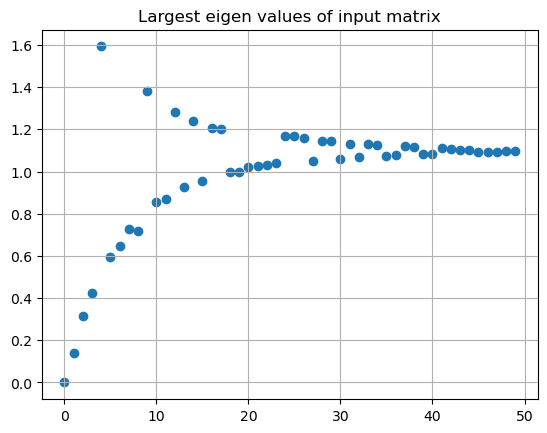

In [11]:
embedding = SpectralEmbedding(n_components=48, affinity='rbf', gamma = 45)
X_transformed = embedding.fit_transform(X)
_, e,  v = eigenDecomposition(embedding.affinity_matrix_)

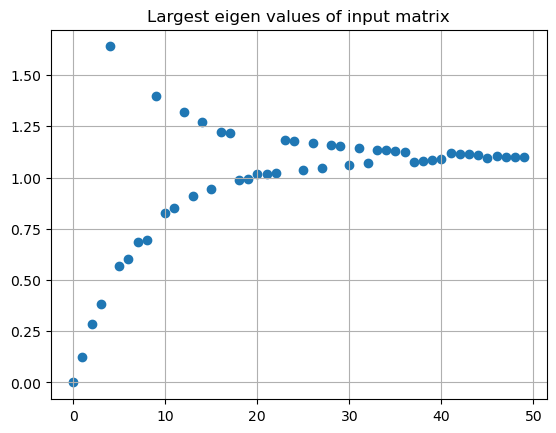

In [22]:
embedding = SpectralEmbedding(n_components=48, affinity='rbf', gamma = 50)
X_transformed = embedding.fit_transform(X)
_, e,  v = eigenDecomposition(embedding.affinity_matrix_)

On trouve une combinaison optimal de gamma = 12.5 et 4 Clusters pour rbf et discretize. En effet, on utilise le fait que nous ne perdons pas trop de score tout en obtenant un bien meilleur coude en prenant cette combinaison comparé aux autres qui donnent un meilleur score. Regardons pour rbf et kmeans :

In [17]:
G = np.linspace(5,100,39)
nb_cluster = [4,5,6,7,8,9,10,11,12,14,16,20]
Score = []
for i in range(len(G)):
    for j in range(len(nb_cluster)):
        clustering = SpectralClustering(n_clusters=nb_cluster[j], assign_labels='kmeans', random_state=0, affinity= 'rbf', gamma = G[i]).fit(X)
        Pred = clustering.labels_
        Score.append(silhouette_score(X, Pred))

temp = []
index = []
taille = 10

for i in range(taille):
    index.append(Score.index(max(Score)))
    temp.append(Score[index[i]])
    Score[index[i]] = 0

for i in range(taille):
    Score[index[i]] = temp[i]

for i in index:
    print(f"Pour gamma = {G[int(i/len(nb_cluster))]} et {nb_cluster[round((i/len(nb_cluster) - int(i/len(nb_cluster))) * 13)]} clusters, le score est de {Score[i]}")

Pour gamma = 22.5 et 4 clusters, le score est de 0.3524225176873786
Pour gamma = 52.5 et 5 clusters, le score est de 0.33864398709287913
Pour gamma = 12.5 et 5 clusters, le score est de 0.3133260102670511
Pour gamma = 5.0 et 4 clusters, le score est de 0.3100244823614206
Pour gamma = 75.0 et 4 clusters, le score est de 0.3092149594252438
Pour gamma = 77.5 et 4 clusters, le score est de 0.3092149594252438
Pour gamma = 80.0 et 4 clusters, le score est de 0.3092149594252438
Pour gamma = 82.5 et 4 clusters, le score est de 0.3092149594252438
Pour gamma = 85.0 et 4 clusters, le score est de 0.3092149594252438
Pour gamma = 87.5 et 4 clusters, le score est de 0.3092149594252438


Ici on obtient un couple de 4 cluster et un gamma de 22.5

In [18]:
N = [3,5,6,7,8,9,10,11,13,15,20]
nb_cluster = [4,5,6,7,8,9,10,11,12,14,16,20]
Score = []
for i in range(len(N)):
    for j in range(len(nb_cluster)):
        clustering = SpectralClustering(n_clusters=nb_cluster[j], assign_labels='discretize', random_state=0, affinity= 'nearest_neighbors', n_neighbors = N[i]).fit(X)
        Pred = clustering.labels_
        Score.append(silhouette_score(X, Pred))

temp = []
index = []
taille = 10

for i in range(taille):
    index.append(Score.index(max(Score)))
    temp.append(Score[index[i]])
    Score[index[i]] = 0

for i in range(taille):
    Score[index[i]] = temp[i]

for i in index:
    print(f"Pour {N[int(i/len(nb_cluster))]} voisins et {nb_cluster[round((i/len(nb_cluster) - int(i/len(nb_cluster))) * 13)]} clusters, le score est de {Score[i]}")

Pour 5 voisins et 4 clusters, le score est de 0.31400889031197177
Pour 6 voisins et 4 clusters, le score est de 0.31400889031197177
Pour 7 voisins et 4 clusters, le score est de 0.29491669381908925
Pour 13 voisins et 4 clusters, le score est de 0.27086461301164977
Pour 9 voisins et 4 clusters, le score est de 0.25903200774419566
Pour 8 voisins et 4 clusters, le score est de 0.25506097515578635
Pour 7 voisins et 5 clusters, le score est de 0.24697104317467106
Pour 9 voisins et 5 clusters, le score est de 0.24613412191416742
Pour 10 voisins et 7 clusters, le score est de 0.23862595686284716
Pour 8 voisins et 5 clusters, le score est de 0.2341368724533002


On va choisir la combinaison de 7 voisins et 4 clusters comme couple optimal. 

In [19]:
N = [3,5,6,7,8,9,10,11,13,15,20]
nb_cluster = [4,5,6,7,8,9,10,11,12,14,16,20]
Score = []
for i in range(len(N)):
    for j in range(len(nb_cluster)):
        clustering = SpectralClustering(n_clusters=nb_cluster[j], assign_labels='kmeans', random_state=0, affinity= 'nearest_neighbors', n_neighbors = N[i]).fit(X)
        Pred = clustering.labels_
        Score.append(silhouette_score(X, Pred))

temp = []
index = []
taille = 10

for i in range(taille):
    index.append(Score.index(max(Score)))
    temp.append(Score[index[i]])
    Score[index[i]] = 0

for i in range(taille):
    Score[index[i]] = temp[i]

for i in index:
    print(f"Pour {N[int(i/len(nb_cluster))]} voisins et {nb_cluster[round((i/len(nb_cluster) - int(i/len(nb_cluster))) * 13)]} clusters, le score est de {Score[i]}")

Pour 7 voisins et 4 clusters, le score est de 0.3204940471212929
Pour 5 voisins et 4 clusters, le score est de 0.3171838972357677
Pour 6 voisins et 4 clusters, le score est de 0.31400889031197177
Pour 20 voisins et 4 clusters, le score est de 0.31060318716834384
Pour 8 voisins et 4 clusters, le score est de 0.25762301069176585
Pour 9 voisins et 4 clusters, le score est de 0.25762301069176585
Pour 11 voisins et 14 clusters, le score est de 0.25621552800348635
Pour 11 voisins et 10 clusters, le score est de 0.2530647819594002
Pour 7 voisins et 5 clusters, le score est de 0.25239704884312575
Pour 9 voisins et 12 clusters, le score est de 0.25103317610165904


Ici, on retrouve aussi la combinaison de 7 voisins et 4 clusters.

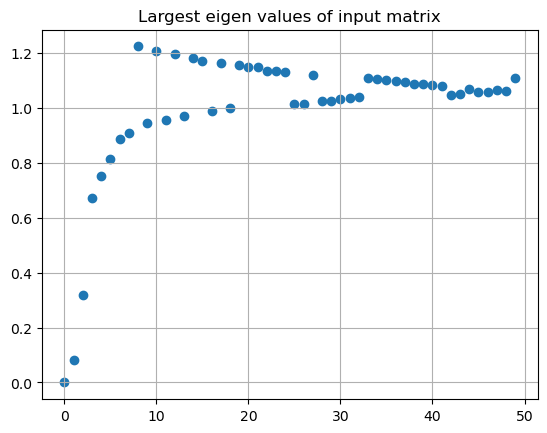

In [30]:
embedding = SpectralEmbedding(n_components=48, affinity='nearest_neighbors', n_neighbors = 15)
X_transformed = embedding.fit_transform(X)
_, e,  v = eigenDecomposition(embedding.affinity_matrix_.toarray())

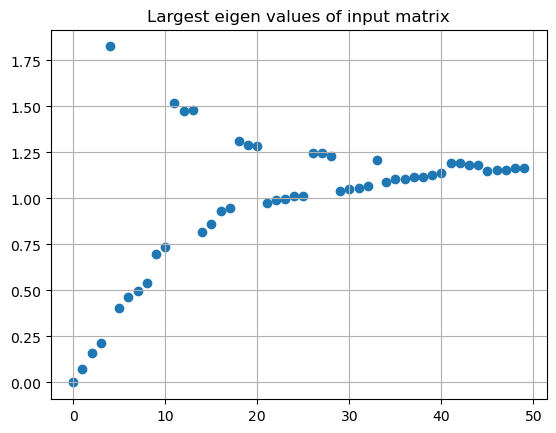

In [19]:
embedding = SpectralEmbedding(n_components=48, affinity='rbf', gamma = 80)
X_transformed = embedding.fit_transform(X)
_, e,  v = eigenDecomposition(embedding.affinity_matrix_)

# Clustering des phénotypes

Maintenant que nous avons pu regarder les résultats du clustering par patient, nous allons regarder celui par phénotypes. Pour cela nous utiliserons la méthode RBF avec l'assignement des labels effectués grâce à la méthode discretize. Nous verrons plus tard pourquoi ce choix ainsi que ses limites.

In [12]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
X1_transformed = embedding.fit_transform(X1)

clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X1)
y1_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X1)
y2_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(X1)
y3_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=8, assign_labels='discretize', random_state=0).fit(X1)
y4_pred = clustering.labels_

Commençons par afficher une première visualitation de ce qu'on pourrait avoir 

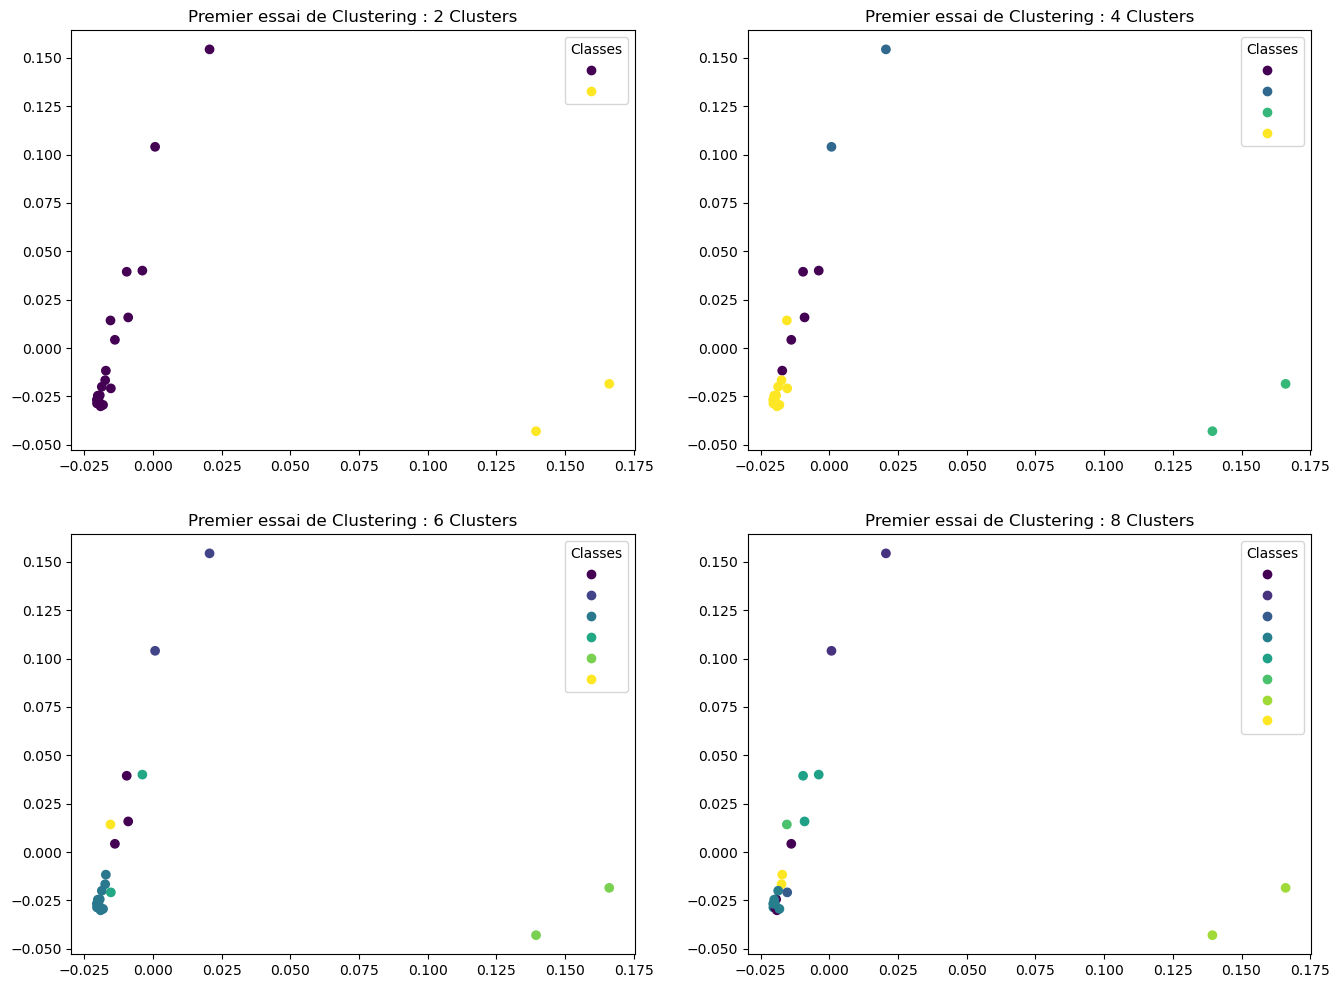

In [13]:
plt.figure(figsize = (16,12))

plt.subplot(2,2,1)
plt.title("Premier essai de Clustering : 2 Clusters")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1],
            c=y1_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0], 
           title="Classes")

plt.subplot(2,2,2)
plt.title("Premier essai de Clustering : 4 Clusters")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1],
            c=y2_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,2,3)
plt.title("Premier essai de Clustering : 6 Clusters")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1],
            c=y3_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,2,4)
plt.title("Premier essai de Clustering : 8 Clusters")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1],
            c=y4_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")


plt.show()

In [10]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
X1_transformed = embedding.fit_transform(X1)

clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X1)
y_pred = clustering.labels_

embedding_ = SpectralEmbedding(n_components=2, affinity='rbf', gamma = 0.5)
X2_transformed = embedding_.fit_transform(X1)

clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0, gamma = 0.5).fit(X1)
y1_pred = clustering.labels_

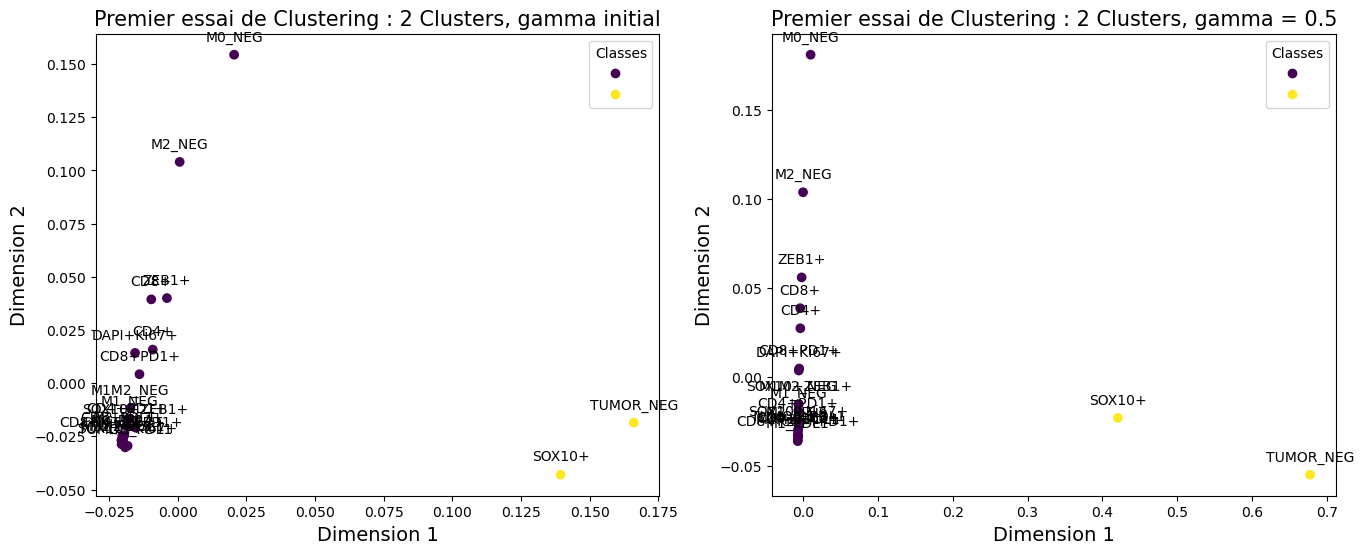

In [12]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
plt.title("Premier essai de Clustering : 2 Clusters, gamma initial", fontsize = 15)
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1],
            c=y_pred)
# add legend to the plot with names
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")
for i in range(len(X1)):
    plt.annotate(X1.index[i],X1_transformed[i], textcoords = "offset points", xytext = (0,10), ha = 'center')
    
plt.subplot(1,2,2)
plt.title("Premier essai de Clustering : 2 Clusters, gamma = 0.5", fontsize = 15)
scatter = plt.scatter(X2_transformed[:,0], 
            X2_transformed[:,1],
            c=y1_pred)
# add legend to the plot with names
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")
for i in range(len(X1)):
    plt.annotate(X1.index[i],X2_transformed[i], textcoords = "offset points", xytext = (0,10), ha = 'center')
plt.show()

Etant donné l'illisibilité de ce graphique, nous faisons, comme avec les patients, un enregistrement des résultats de nos Cluster afin de savoir qui a été Clusterisé avec qui.

In [33]:
X1['8 Cluster'] = y4_pred
X1['6 Cluster'] = y3_pred
X1['4 Cluster'] = y2_pred
X1['2 Cluster'] = y1_pred

for i in range(8):    
    print(f'Les membres du Cluster {i} sont : ', X1.index[X1['8 Cluster'] == i])

Les membres du Cluster 0 sont :  Index(['M2_PDL1', 'TUMOR_PDL1', 'M1M2_PDL1', 'CD8+PD1+'], dtype='object')
Les membres du Cluster 1 sont :  Index(['M2_NEG', 'M0_NEG'], dtype='object')
Les membres du Cluster 2 sont :  Index(['SOX10+ZEB1+'], dtype='object')
Les membres du Cluster 3 sont :  Index(['M1_PDL1', 'M0_PDL1', 'SOX10+Ki67+', 'CD4+PD1+', 'CD4+Ki67+',
       'CD8+Ki67+', 'CD8+Ki67+PD1+'],
      dtype='object')
Les membres du Cluster 4 sont :  Index(['CD8+', 'CD4+', 'ZEB1+'], dtype='object')
Les membres du Cluster 5 sont :  Index(['DAPI+Ki67+'], dtype='object')
Les membres du Cluster 6 sont :  Index(['TUMOR_NEG', 'SOX10+'], dtype='object')
Les membres du Cluster 7 sont :  Index(['M1M2_NEG', 'M1_NEG'], dtype='object')


X1 étant modifié, on le remet comme à l'origine.

In [34]:
X = df[df.columns[1:-1]]
Y = df[df.columns[-1]]

X1 = X.T

On va maintenant chercher le gamma optimal :

In [35]:
  
G = np.linspace(5,100,39)
nb_cluster = [4,5,6,7,8,9,10,11,12,14,16,20]
Score = []
for i in range(len(G)):
    for j in range(len(nb_cluster)):
        clustering = SpectralClustering(n_clusters=nb_cluster[j], assign_labels = 'discretize', random_state=0, affinity= 'rbf', gamma = G[i]).fit(X1)
        Pred = clustering.labels_
        Score.append(silhouette_score(X1, Pred))

temp = []
index = []
taille = 10

for i in range(taille):
    index.append(Score.index(max(Score)))
    temp.append(Score[index[i]])
    Score[index[i]] = 0

for i in range(taille):
    Score[index[i]] = temp[i]

for i in index:
    print(f"Pour gamma = {G[int(i/len(nb_cluster))]} et {nb_cluster[round((i/len(nb_cluster) - int(i/len(nb_cluster))) * 13)]} clusters, le score est de {Score[i]}")

Pour gamma = 7.5 et 4 clusters, le score est de 0.6238452582716905
Pour gamma = 10.0 et 4 clusters, le score est de 0.6238452582716905
Pour gamma = 12.5 et 4 clusters, le score est de 0.6238452582716905
Pour gamma = 5.0 et 4 clusters, le score est de 0.4484193508515265
Pour gamma = 5.0 et 5 clusters, le score est de 0.4463625994530851
Pour gamma = 25.0 et 5 clusters, le score est de 0.40359744112269225
Pour gamma = 32.5 et 5 clusters, le score est de 0.40359744112269225
Pour gamma = 35.0 et 5 clusters, le score est de 0.40359744112269225
Pour gamma = 42.5 et 5 clusters, le score est de 0.40359744112269225
Pour gamma = 45.0 et 5 clusters, le score est de 0.40359744112269225


On va regarder quand est-ce que nous obtenons un coude pour l'embedding

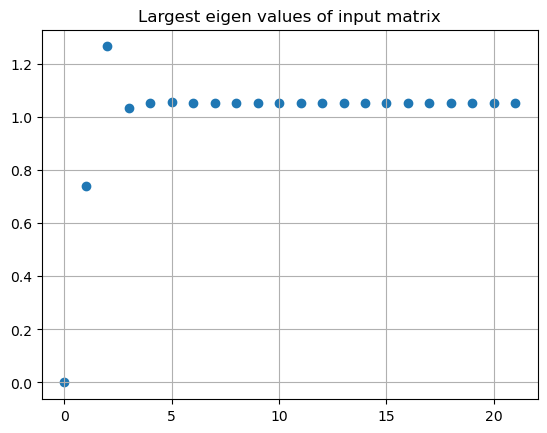

In [26]:
embedding = SpectralEmbedding(n_components=20, affinity='rbf', gamma = 0.5)
X1_transformed = embedding.fit_transform(X1)
k, _, _= eigenDecomposition(embedding.affinity_matrix_)

On semble obtenir un coude lorsque gamma vaut 10 on va le choisir comme gamma optimal.

Maintenant qu'on a nos paramètres optimaux, on peut afficher otutes les dimensions.

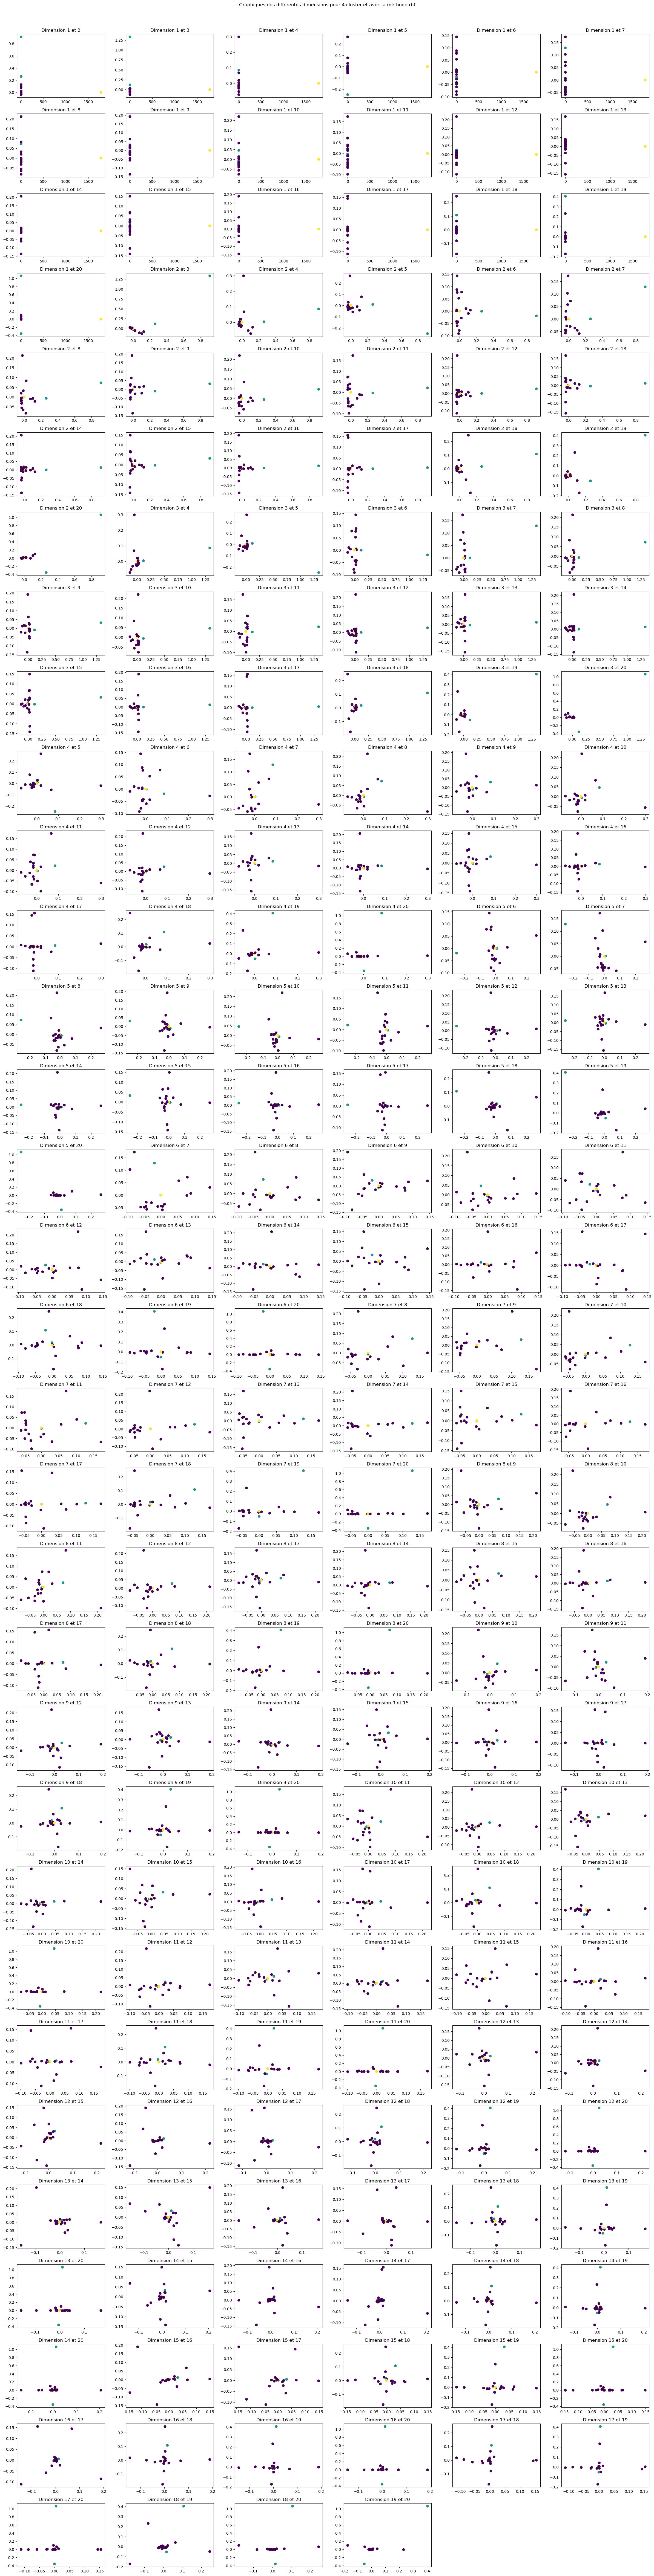

In [37]:
affiche(X1, 20, 4, gamma = 10, g = 10)

La raison pour laquelle nous avons fait tout cela uniquement avec la méthode rbf discretize est la suivante : Notre graphe n'est pas connecté complétement ce qui nous empêche d'obtenir ce que nous cherchons. Cependant, cela est une "bonne chose" en soit car cela veut dire qu'il y a bien des phénotypes qui ne sont pas réellement associés à d'autres. 


In [38]:
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
X1_transformed = embedding.fit_transform(X1)

c:\Users\juni1\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Nous regardons plus en détail la matrice d'affinité et les connections dans un autre notebook 

Regardons si nous avons un lien entre les clusters trouvé et les éléments du graphique lié entre eux (i.e ceux qui restent côte à côte dans le graphique)

In [39]:
X_test = []
l = []
for i in range(len(X1_transformed[:,0])):
    if round(X1_transformed[:,0][i],10) in l:
        X_test.append(l.index(round(X1_transformed[:,0][i],10)))
    else:
        l.append(round(X1_transformed[:,0][i],10))
        X_test.append(l.index(round(X1_transformed[:,0][i],10)))       

Y_test = []
l = []
for i in range(len(X1_transformed[:,1])):
    if round(X1_transformed[:,1][i],10) in l:
        Y_test.append(l.index(round(X1_transformed[:,1][i],10)))
    else:
        l.append(round(X1_transformed[:,1][i],10))
        Y_test.append(l.index(round(X1_transformed[:,1][i],10)))       
        
X_test == Y_test

True

In [40]:
for j in range(len(l)):
    print(f'Les phénotypes présents dans le groupe {j} sont :')
    for i in range(len(X_test)):
        if X_test[i] == j:
            print(X1.index[i])

Les phénotypes présents dans le groupe 0 sont :
M2_NEG
M0_NEG
CD8+
CD4+
ZEB1+
Les phénotypes présents dans le groupe 1 sont :
TUMOR_NEG
SOX10+
Les phénotypes présents dans le groupe 2 sont :
M1M2_NEG
M1_NEG
DAPI+Ki67+
CD8+PD1+
Les phénotypes présents dans le groupe 3 sont :
M1_PDL1
M0_PDL1
SOX10+Ki67+
CD4+PD1+
CD4+Ki67+
CD8+Ki67+
CD8+Ki67+PD1+
SOX10+ZEB1+
Les phénotypes présents dans le groupe 4 sont :
M2_PDL1
TUMOR_PDL1
M1M2_PDL1


In [41]:
clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=0, affinity= 'rbf', gamma = 5).fit(X1)
y_pred = clustering.labels_

In [42]:
for j in range(5):
    print(f'Les phénotypes présents dans le groupe {j} sont :')
    for i in range(len(y_pred)):
        if y_pred[i] == j:
            print(X1.index[i])

Les phénotypes présents dans le groupe 0 sont :
DAPI+Ki67+
CD8+PD1+
Les phénotypes présents dans le groupe 1 sont :
M2_NEG
M0_NEG
Les phénotypes présents dans le groupe 2 sont :
TUMOR_NEG
SOX10+
Les phénotypes présents dans le groupe 3 sont :
CD8+
CD4+
ZEB1+
Les phénotypes présents dans le groupe 4 sont :
M1M2_NEG
M1_NEG
M1_PDL1
M2_PDL1
TUMOR_PDL1
M1M2_PDL1
M0_PDL1
SOX10+Ki67+
CD4+PD1+
CD4+Ki67+
CD8+Ki67+
CD8+Ki67+PD1+
SOX10+ZEB1+


On se retrouve, comme vu ci-dessous avec seulement 5 points différents.

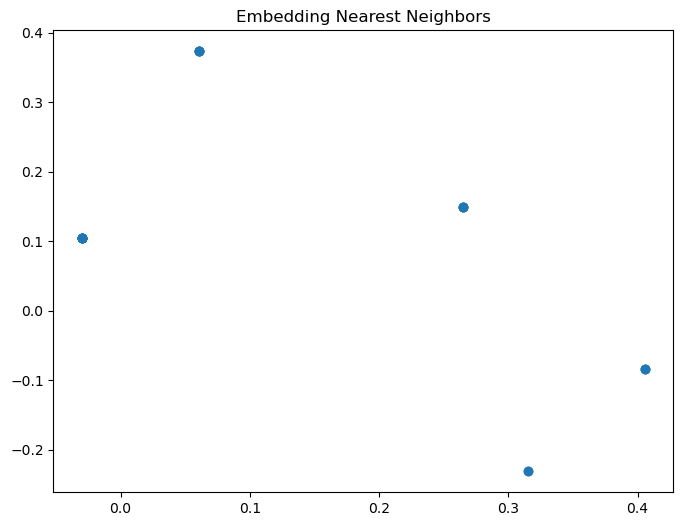

In [43]:
plt.figure(figsize = (8,6))
plt.title("Embedding Nearest Neighbors")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1])
plt.show()

### Normalisation des données 

In [44]:
scaler = MinMaxScaler()
scaler1 = StandardScaler()

Xnorm = scaler.fit_transform(X)
Xnorm1 = scaler1.fit_transform(X)

X1norm = scaler.fit_transform(X1)
X1norm1 = scaler1.fit_transform(X1)

In [45]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
Xnorm_transformed = embedding.fit_transform(Xnorm)

emb = SpectralEmbedding(n_components=2, affinity='rbf')
Xnorm1_transformed = emb.fit_transform(Xnorm1)

emb1 = SpectralEmbedding(n_components=2, affinity='rbf')
X_transformed = emb1.fit_transform(X)

In [46]:
clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(Xnorm)
y1_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(Xnorm1)
y2_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X)
y3_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(Xnorm)
y4_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(Xnorm1)
y5_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(X)
y6_pred = clustering.labels_

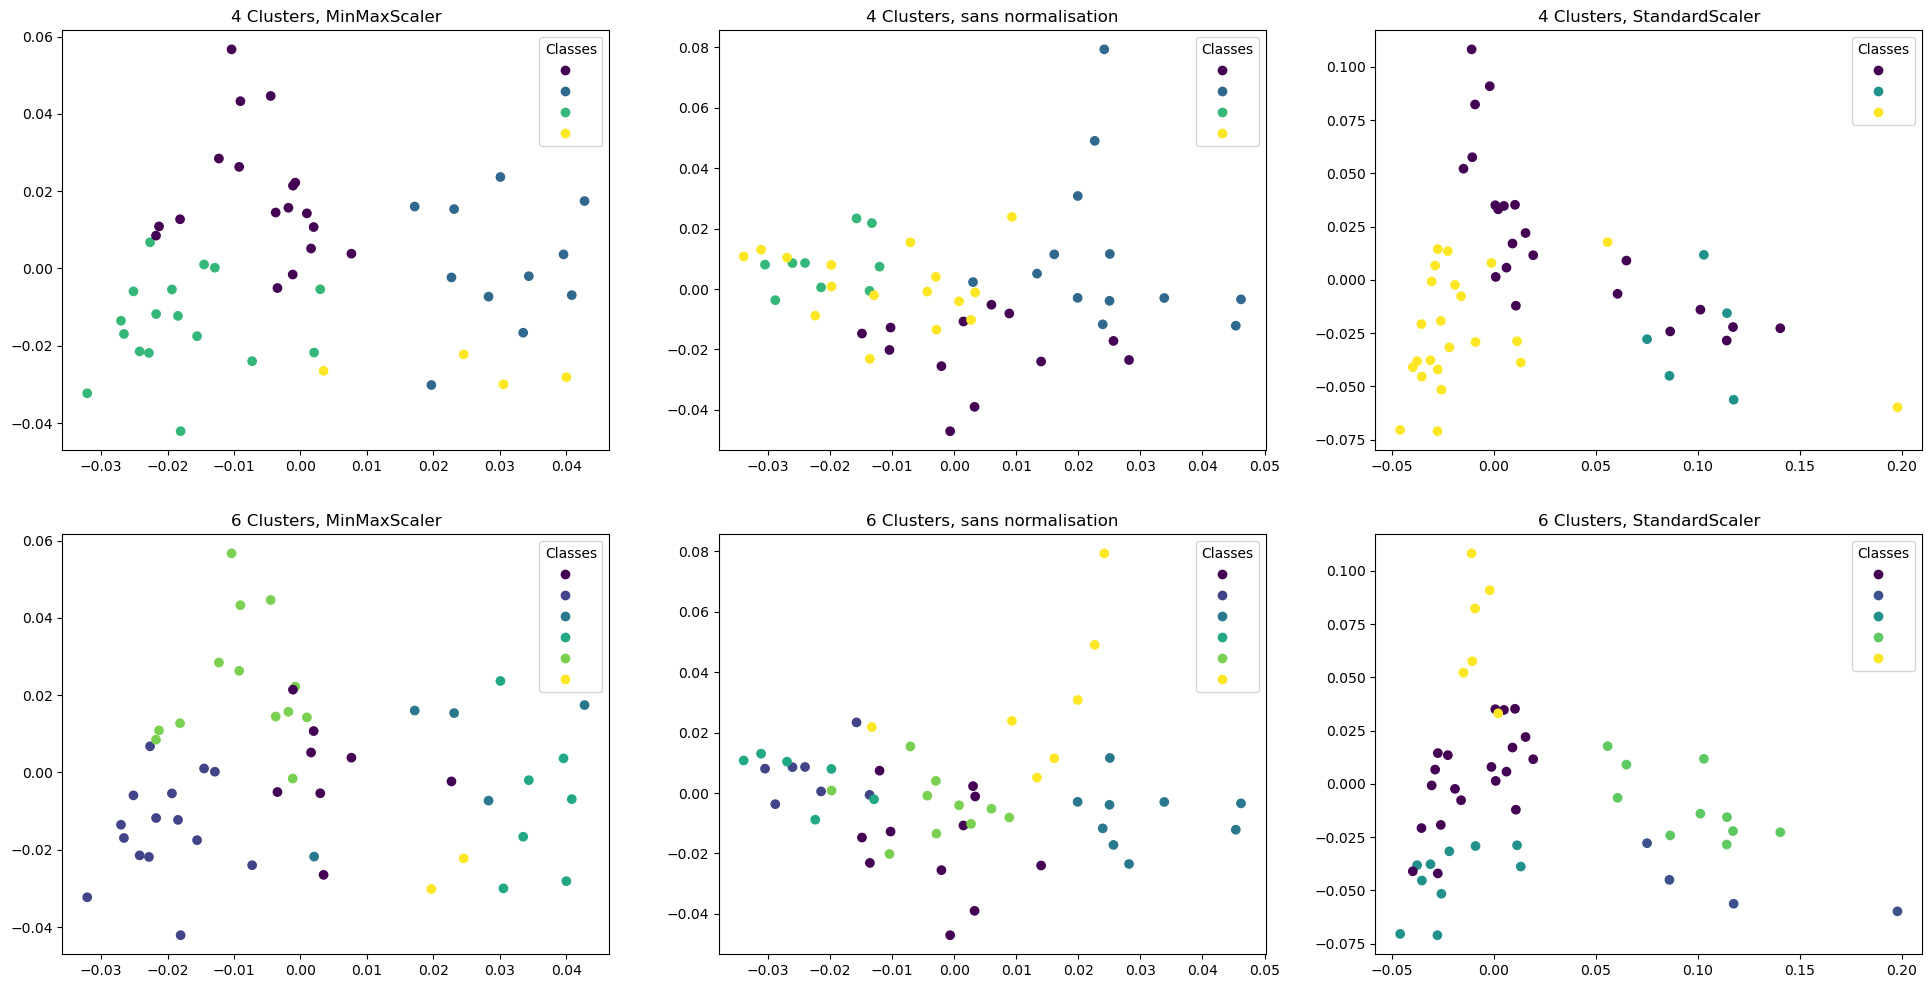

In [47]:
plt.figure(figsize = (24,12))

plt.subplot(2,3,1)
plt.title("4 Clusters, MinMaxScaler")
scatter = plt.scatter(Xnorm_transformed[:,0], 
            Xnorm_transformed[:,1],
            c=y1_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0], 
           title="Classes")

plt.subplot(2,3,2)
plt.title("4 Clusters, sans normalisation")
scatter = plt.scatter(X_transformed[:,0], 
            X_transformed[:,1],
            c=y3_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,3,3)
plt.title("4 Clusters, StandardScaler")
scatter = plt.scatter(Xnorm1_transformed[:,0], 
            Xnorm1_transformed[:,1],
            c=y2_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,3,4)
plt.title("6 Clusters, MinMaxScaler")
scatter = plt.scatter(Xnorm_transformed[:,0], 
            Xnorm_transformed[:,1],
            c=y4_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,3,5)
plt.title("6 Clusters, sans normalisation")
scatter = plt.scatter(X_transformed[:,0], 
            X_transformed[:,1],
            c=y6_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")

plt.subplot(2,3,6)
plt.title("6 Clusters, StandardScaler")
scatter = plt.scatter(Xnorm1_transformed[:,0], 
            Xnorm1_transformed[:,1],
            c=y5_pred)
# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0],
           title="Classes")


plt.show()

In [48]:
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
Xnorm_transformed = embedding.fit_transform(X1norm)

emb = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
Xnorm1_transformed = emb.fit_transform(X1norm1)

emb1 = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
X1_transformed = emb1.fit_transform(X1)

c:\Users\juni1\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\juni1\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\juni1\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [49]:
clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X1norm)
y1_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X1norm1)
y2_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X1)
y3_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(X1norm)
y4_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(X1norm1)
y5_pred = clustering.labels_

clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', random_state=0).fit(X1)
y6_pred = clustering.labels_

In [50]:
for j in range(4):
    print(f'Les phénotypes présents dans le groupe {j} sont :')
    for i in range(len(y1_pred)):
        if y1_pred[i] == j:
            print(X1.index[i])

Les phénotypes présents dans le groupe 0 sont :
M2_NEG
CD8+
Les phénotypes présents dans le groupe 1 sont :
M0_NEG
Les phénotypes présents dans le groupe 2 sont :
TUMOR_NEG
SOX10+
Les phénotypes présents dans le groupe 3 sont :
M1M2_NEG
M1_NEG
M1_PDL1
M2_PDL1
TUMOR_PDL1
M1M2_PDL1
M0_PDL1
CD4+
ZEB1+
DAPI+Ki67+
SOX10+Ki67+
CD4+PD1+
CD4+Ki67+
CD8+Ki67+
CD8+PD1+
CD8+Ki67+PD1+
SOX10+ZEB1+


In [51]:
for j in range(4):
    print(f'Les phénotypes présents dans le groupe {j} sont :')
    for i in range(len(y2_pred)):
        if y2_pred[i] == j:
            print(X1.index[i])

Les phénotypes présents dans le groupe 0 sont :
M1M2_NEG
M1_NEG
M2_PDL1
TUMOR_PDL1
DAPI+Ki67+
CD4+PD1+
CD8+PD1+
Les phénotypes présents dans le groupe 1 sont :
M2_NEG
SOX10+
CD8+
CD4+
ZEB1+
Les phénotypes présents dans le groupe 2 sont :
TUMOR_NEG
M0_NEG
M1_PDL1
M1M2_PDL1
M0_PDL1
SOX10+Ki67+
CD4+Ki67+
CD8+Ki67+
CD8+Ki67+PD1+
SOX10+ZEB1+
Les phénotypes présents dans le groupe 3 sont :


In [52]:
for j in range(4):
    print(f'Les phénotypes présents dans le groupe {j} sont :')
    for i in range(len(y3_pred)):
        if y3_pred[i] == j:
            print(X1.index[i])

Les phénotypes présents dans le groupe 0 sont :
M1M2_NEG
CD8+
CD4+
ZEB1+
CD8+PD1+
Les phénotypes présents dans le groupe 1 sont :
M2_NEG
M0_NEG
Les phénotypes présents dans le groupe 2 sont :
TUMOR_NEG
SOX10+
Les phénotypes présents dans le groupe 3 sont :
M1_NEG
M1_PDL1
M2_PDL1
TUMOR_PDL1
M1M2_PDL1
M0_PDL1
DAPI+Ki67+
SOX10+Ki67+
CD4+PD1+
CD4+Ki67+
CD8+Ki67+
CD8+Ki67+PD1+
SOX10+ZEB1+


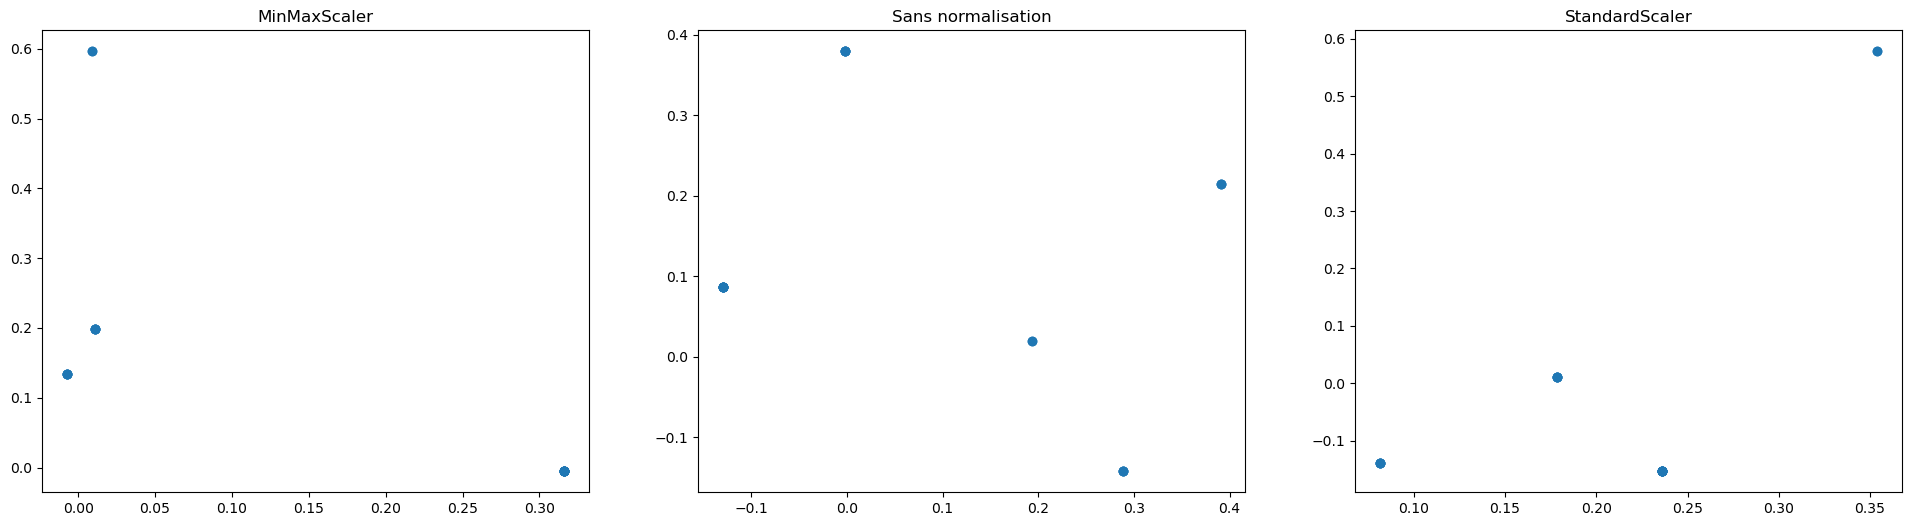

In [53]:
plt.figure(figsize = (24,6))

plt.subplot(1,3,1)
plt.title("MinMaxScaler")
scatter = plt.scatter(Xnorm_transformed[:,0], 
            Xnorm_transformed[:,1])

plt.subplot(1,3,2)
plt.title("Sans normalisation")
scatter = plt.scatter(X1_transformed[:,0], 
            X1_transformed[:,1])

plt.subplot(1,3,3)
plt.title("StandardScaler")
scatter = plt.scatter(Xnorm1_transformed[:,0], 
            Xnorm1_transformed[:,1])

plt.show()

Normaliser les données patient et phénotype